In [12]:
def transmissionProcess(N,initialN=0,lambda1=1,lambda2=0,lambda3=0,p_b = 0,plt = 0,z_end=0):
    #initialisation of SIRSCN
    C = N.copy()
    z = 0 # infection event count
    n = C.order() #total number of nodes
    infectedNs = [initialN]
    recoveredNs = []
    n_i = [1]
    n_s = [n-1]
    n_r = [0] #put number of SIR in lists for easy plotting later on
    C.set_vertex(initialN,'i')
    lex = {e:[0,0] for e in range(n)} #lexicon. [#how many nodes infected,#times infected]
    lex[initialN] = [0,1]
    currentSOE = susceptibleOutEdges(C,infectedNs)
    if p_b > 0:
        for e in currentSOE:              
            if random() < p_b:                       
                C.set_edge_label(e[0],e[1],'b')
                currentSOE.remove(e)   
    # initialisation of Transmission Tree
    pathsDict={} # dictionary of nodes -> paths from root in tree
    LBT = LabelledBinaryTree
    # individuals in tree are labelled by "n"+str(integer_label)
    T = LBT([None,None],label="n"+str(initialN)).clone()
    pathsDict["n"+str(initialN)]=[]
    while (n_i[-1] > 0 and lambda2 > 0) or (n_s[-1] > 0 and lambda2 == 0):
        z=z+1
        p = random()
        m = len(currentSOE)
        p_inf = m*lambda1/(m*lambda1+n_i[-1]*lambda2+n_r[-1]*lambda3) #s -> i
        p_rec = n_i[-1]*lambda2/(len(currentSOE)*lambda1+n_i[-1]*lambda2+n_r[-1]*lambda3) #i -> r
        if 0 < p < p_inf: #infection event
            next_edge = currentSOE.pop(randrange(0,m)) #find next edge
            infectedNs.append(next_edge[1])
            C.set_vertex(next_edge[1],'i')
            currentSOE = [e for e in currentSOE if e[1] != next_edge[1]] #remove edges leading to this new infected node
            new_SOE = susceptibleOutEdges(C,next_edge[1])
            if p_b > 0:
                for e in C.outgoing_edge_iterator(next_edge[1]):  
                    if e[2] == 'b':
                        C.set_edge_label(e[0],e[1],None)
                    if random() < p_b:#*n_i[-1]/n:                       
                        C.set_edge_label(e[0],e[1],'b')
                        if e in new_SOE:
                            new_SOE.remove(e)
            currentSOE = currentSOE+ new_SOE #add new susceptible edges
            n_s.append(n_s[-1]-1)
            n_i.append(n_i[-1]+1)
            n_r.append(n_r[-1])
            T=growTransmissionTree(T, pathsDict, z, "n"+str(next_edge[0]),"n"+str(next_edge[1]))
            lex[next_edge[0]][0] += 1 #add stuff to lexicon
            lex[next_edge[1]][1] += 1
        elif p_inf < p < p_inf+p_rec:  #recovery event
            next_node = infectedNs.pop(randrange(0,len(infectedNs)))
            currentSOE = [e for e in currentSOE if e[0] != next_node] #remove edges coming from this node                            
            if lambda3 == -1: #skip recovery, go straight to susceptible
                C.set_vertex(next_node,None)
                currentSOE = currentSOE+infectedInEdges(C,next_node)
                n_i.append(n_i[-1]-1)
                n_r.append(n_r[-1])
                n_s.append(n_s[-1]+1)
            else:
                recoveredNs.append(next_node)
                C.set_vertex(next_node,'r')
                n_i.append(n_i[-1]-1)
                n_s.append(n_s[-1])
                n_r.append(n_r[-1]+1)
        else:
            next_node = recoveredNs.pop(randrange(0,len(recoveredNs)))
            C.set_vertex(next_node,None)
            currentSOE = currentSOE+infectedInEdges(C,next_node)
            n_i.append(n_i[-1])
            n_r.append(n_r[-1]-1)
            n_s.append(n_s[-1]+1)
        #print(ascii_art(T))
        #print "step z = ",z; print ascii_art(T); print "--------------------"
        if (z_end != 0) and (z == z_end):
            print(f"{z_end} events, stopping simulation.")
            converge = 0
            break       
    if n_i[-1] == 0:
        converge = 1    
    if plt == 1:
        iplotvalues = [(i,e) for i,e in enumerate(n_i)]
        splotvalues = [(i,e) for i,e in enumerate(n_s)]
        iplot = line(iplotvalues, color='red', legend_label='Infected', legend_color='red',axes_labels=['Event','Count'])
        splot = line(splotvalues, color='green', legend_label='Susceptible', legend_color='green',axes_labels=['Event','Count'])
        plotter = splot+iplot
        if (lambda2 > 0) and (lambda3 != -1):        
            rplotvalues = [(i,e) for i,e in enumerate(n_r)]
            rplot = line(rplotvalues, color='blue', legend_label='Recovered', legend_color='blue',axes_labels=['Event','Count'])            
            plotter = plotter + rplot
        show(plotter)
        #print("Parameters: lambda1 = "+str(lambda1)+", lambda2 = "+str(lambda2)+", lambda3 = "+str(lambda3)+", p_block = "+str(RR(p_b)))
    return [[n_s,n_i,n_r,lex,z,converge],T.as_ordered_tree(with_leaves=False)]

def CountsDict(X):
    '''convert a list X into a Dictionary of counts or frequencies'''
    CD = {}
    for x in X:
        CD[x] = (CD[x] + 1) if (x in CD) else 1
    return CD
        
def susceptibleOutEdges(C,vs):
    '''return the the susceptible outedges of node v in vs in SICN C'''
    SOE = [e for e in C.outgoing_edge_iterator(vs) if C.get_vertex(e[1])==None]
    return SOE    

def infectedInEdges(C,vs):
    '''return the the infected inedges of node v in vs in SICN C'''
    SOE = [e for e in C.incoming_edge_iterator(vs) if (C.get_vertex(e[0])=='i') and (e[2] !='b')]
    return SOE

def growTransmissionTree(Ttree, pDict, z, infector, infectee):
    '''grow the transmission tree Ttree and update pathsDict pDict by adding the
        z-th infection event with infector -> infectee '''
    LBT = LabelledBinaryTree
    newSubTree = LBT([LBT([None,None], label=infector), LBT([None, None], label=infectee)], label=z).clone()
    path2Infector = pDict[infector]
    if z==1:
        Ttree = newSubTree
    else:
        Ttree[tuple(path2Infector)] =newSubTree
    #print ascii_art(Ttree)
    pDict[infector]=path2Infector+[0]
    pDict[infectee]=path2Infector+[1]
    pDict[z]=path2Infector
    return Ttree

def SIS(C,lambda1=1,lambda2=1,z_end=5000,plt=0):
    return transmissionProcess(C,0,lambda1,lambda2,-1,0, plt,z_end)

def SIR(C,lambda1=1,lambda2=1,plt=0):
    return transmissionProcess(C,0,lambda1,lambda2,0,0,plt,z_end=0)

def SIRS(C,lambda1=1,lambda2=1,lambda3=1,z_end = 3000,plt=0,p_b=0):
    return transmissionProcess(C,0,lambda1,lambda2,lambda3,p_b,plt,z_end)

15000 events, stopping simulation.


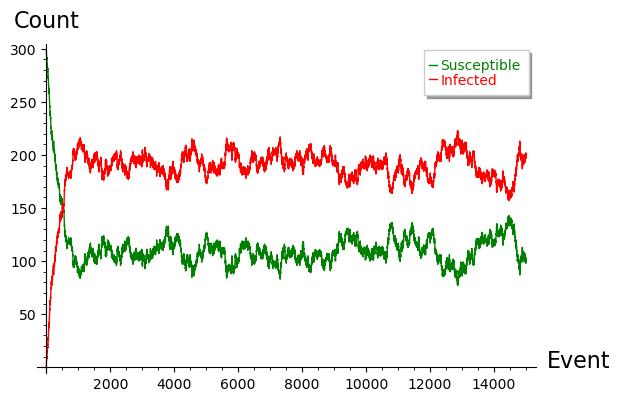

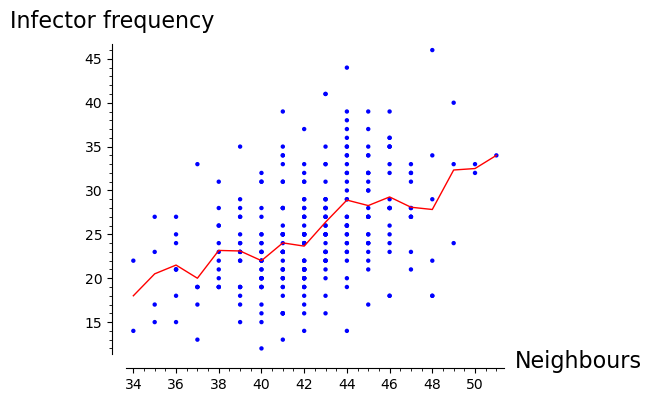

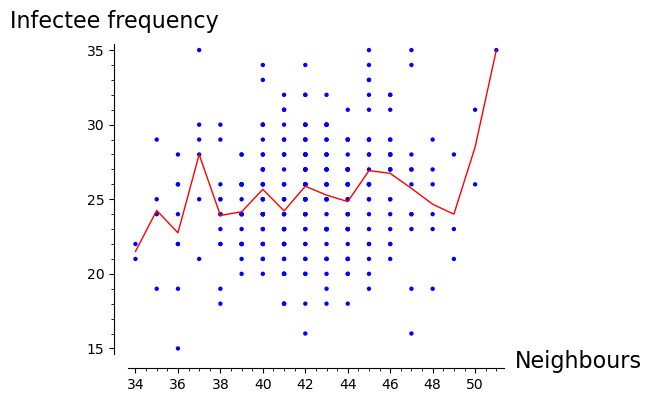

In [17]:
#SIS simulations
#Small World
from sage.plot.density_plot import DensityPlot
n = 300
k0 = n/10
p = 0.4
k = graphs.RandomNewmanWattsStrogatz(n, k0,p).to_directed()
t = transmissionProcess(k,0,1,15,-1,0,1,15000)
l = t[0][3]
k2 = list(l.values())

node_lex_ic = {}
for i in range(n):
    node_lex_ic[i] = k.out_degree(i)
    
node_lex2_ic = {}
for i,e in enumerate(node_lex_ic.values()):
    node_lex2_ic[e] = (node_lex2_ic[e] + [i]) if (e in node_lex2_ic) else [i]

ic_lex = {}
for i,e in enumerate(node_lex2_ic):
    ic_lex[e] = [l[y][0] for y in node_lex2_ic[e]]
    
plot_values_ic = []
for i in ic_lex:
    for j in ic_lex[i]:
        plot_values_ic.append((i,j))  

plot_mean_ic = sorted([(e,mean(ic_lex[e])) for e in ic_lex])
pl = line(plot_mean_ic,color='red',axes_labels=["Neighbours","Infector frequency"])
pl2 = points(plot_values_ic,color='blue')
show(pl+pl2)
     
    

node_lex_ti = {}
for i in range(n):
    node_lex_ti[i] = k.in_degree(i)     
    
node_lex2_ti = {}
for i,e in enumerate(node_lex_ti.values()):
    node_lex2_ti[e] = (node_lex2_ti[e] + [i]) if (e in node_lex2_ti) else [i]
    
ti_lex = {}
for i,e in enumerate(node_lex2_ti):
    ti_lex[e] = [l[y][1] for y in node_lex2_ti[e]]
    
plot_values_ti = []
for i in ti_lex:
    for j in ti_lex[i]:
        plot_values_ti.append((i,j))
        


plot_mean_ti = sorted([(e,mean(ti_lex[e])) for e in ti_lex])
pl = line(plot_mean_ti,color='red',axes_labels=["Neighbours","Infectee frequency"])
pl2 = points(plot_values_ti,color='blue')
show(pl+pl2)   



5000 events, stopping simulation.


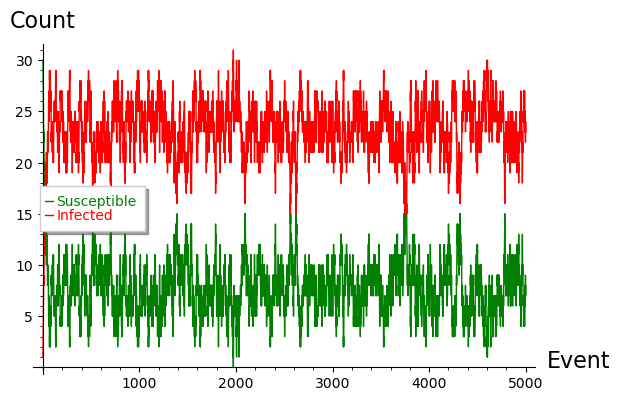

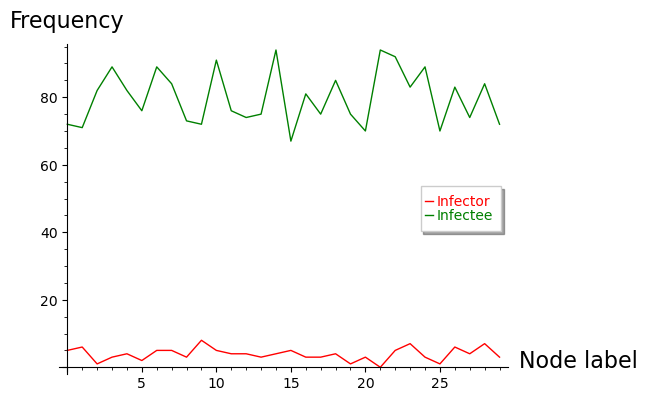

infected nodes, mean  23.2395520895821
infected nodes, std  2.66627142641857
susceptible nodes, mean  7.76044791041792
susceptible nodes, std  2.66627142641857
Infected per node, mean:  3.90000000000000
Infected per node, std:  1.88185528411321
times been infected, mean:  79.8000000000000
times been infected, std:  7.99310047305886
Star node:  [2394, 118]
z = 5000


In [2]:
#SIS simulations
#Star
n = 30
k = graphs.StarGraph(n).to_directed()
t = transmissionProcess(k,0,3,1,-1,0,1,5000)
l = t[0][3]
k = [l[i] for i in range(len(l)) if i != 0]
infected = [e[0] for e in k]
been_inf = [e[1] for e in k]
plotvalues1 = [(i,infected[i]) for i in range(len(infected))]
plotvalues2 = [(i,been_inf[i]) for i in range(len(been_inf))]
plot1 = line(plotvalues1, color = 'red',legend_label='Infector', legend_color='red',axes_labels=['Node label','Frequency'])
plot2 = line(plotvalues2, color = 'green',legend_label='Infectee', legend_color='green',axes_labels=['Node label','Frequency'])
show(plot1+plot2)
print('infected nodes, mean ',RR(mean(t[0][1])))
print('infected nodes, std ',RR(std(t[0][1])))
print('susceptible nodes, mean ',RR(mean(t[0][0])))
print('susceptible nodes, std ',RR(std(t[0][0])))
print('Infected per node, mean: ',RR(mean(infected)))
print('Infected per node, std: ',RR(std(infected)))
print('times been infected, mean: ',RR(mean(been_inf)))
print('times been infected, std: ',RR(std(been_inf)))
print('Star node: ',l[0])
print("z = "+str(t[0][4]))

15000 events, stopping simulation.


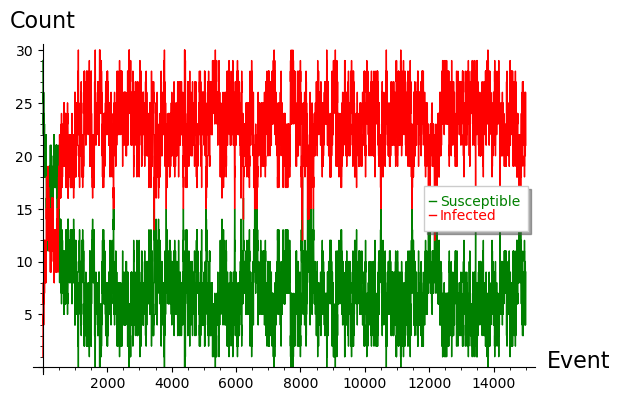

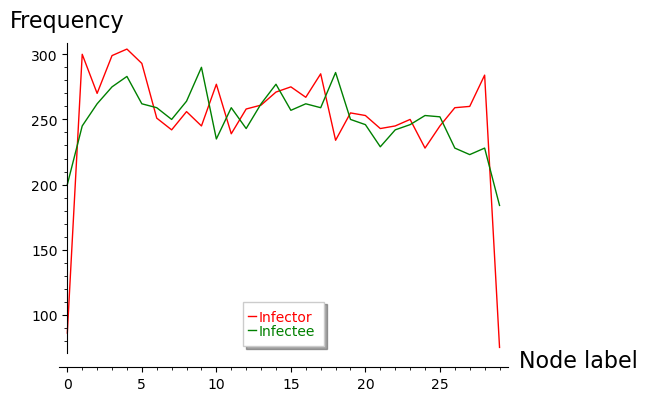

infected nodes, mean  22.6618892073862
infected nodes, std  3.40909667468146
susceptible nodes, mean  7.33811079261383
susceptible nodes, std  3.40909667468146
Infected per node, mean:  250.333333333333
Infected per node, std:  50.3555176809805
times been infected, mean:  250.366666666667
times been infected, std:  23.3422560936219
z = 15000


In [5]:
#SIS simulations
#path
n = 30
k = graphs.PathGraph(n).to_directed()
t = SIS(k,3,1,15000,1)
l = t[0][3]
k = [l[i] for i in range(len(l))]
infected = [e[0] for e in k]
been_inf = [e[1] for e in k]
plotvalues1 = [(i,infected[i]) for i in range(len(infected))]
plotvalues2 = [(i,been_inf[i]) for i in range(len(been_inf))]
plot1 = line(plotvalues1, color = 'red',legend_label='Infector', legend_color='red',axes_labels=['Node label','Frequency'])
plot2 = line(plotvalues2, color = 'green',legend_label='Infectee', legend_color='green',axes_labels=['Node label','Frequency'])
show(plot1+plot2)
print('infected nodes, mean ',RR(mean(t[0][1])))
print('infected nodes, std ',RR(std(t[0][1])))
print('susceptible nodes, mean ',RR(mean(t[0][0])))
print('susceptible nodes, std ',RR(std(t[0][0])))
print('Infected per node, mean: ',RR(mean(infected)))
print('Infected per node, std: ',RR(std(infected)))
print('times been infected, mean: ',RR(mean(been_inf)))
print('times been infected, std: ',RR(std(been_inf)))
print("z = "+str(t[0][4]))

15000 events, stopping simulation.


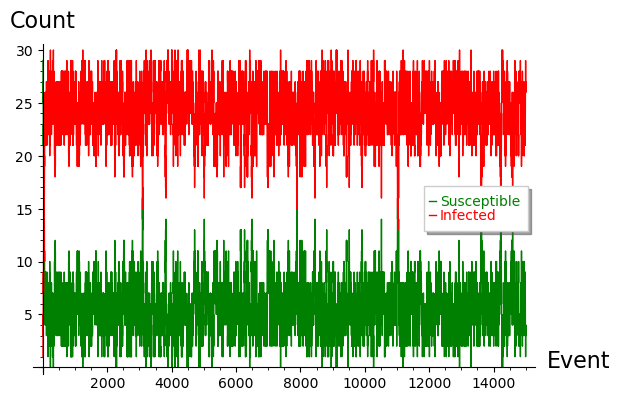

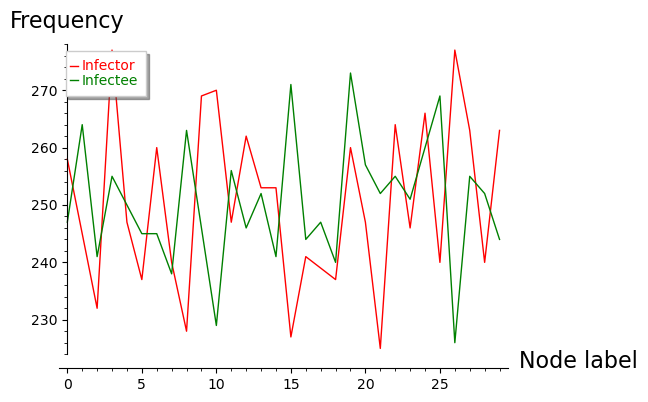

infected nodes, mean  24.2931137924138
infected nodes, std  2.45313647744755
susceptible nodes, mean  5.70688620758616
susceptible nodes, std  2.45313647744755
Infected per node, mean:  250.433333333333
Infected per node, std:  14.7383696598330
times been infected, mean:  250.466666666667
times been infected, std:  11.0757060437615
z = 15000


In [6]:
#SIS simulations
#complete
n = 30
k = graphs.CompleteGraph(n).to_directed()
t = transmissionProcess(k,0,1,5,-1,0,1,15000)
l = t[0][3]
k = [l[i] for i in range(len(l))]
infected = [e[0] for e in k]
been_inf = [e[1] for e in k]
plotvalues1 = [(i,infected[i]) for i in range(len(infected))]
plotvalues2 = [(i,been_inf[i]) for i in range(len(been_inf))]
plot1 = line(plotvalues1, color = 'red',legend_label='Infector', legend_color='red',axes_labels=['Node label','Frequency'])
plot2 = line(plotvalues2, color = 'green',legend_label='Infectee', legend_color='green',axes_labels=['Node label','Frequency'])
show(plot1+plot2)
print('infected nodes, mean ',RR(mean(t[0][1])))
print('infected nodes, std ',RR(std(t[0][1])))
print('susceptible nodes, mean ',RR(mean(t[0][0])))
print('susceptible nodes, std ',RR(std(t[0][0])))
print('Infected per node, mean: ',RR(mean(infected)))
print('Infected per node, std: ',RR(std(infected)))
print('times been infected, mean: ',RR(mean(been_inf)))
print('times been infected, std: ',RR(std(been_inf)))
print("z = "+str(t[0][4]))

40 seconds elapsed, stopping simulation.


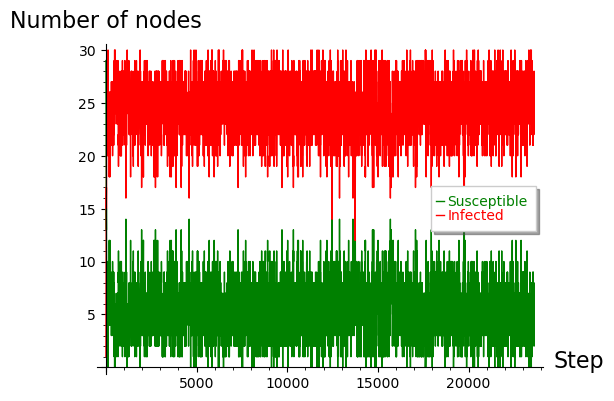

Parameters: lambda1 = 1, lambda2 = 5, lambda3 = -1, p_block = 0.000000000000000


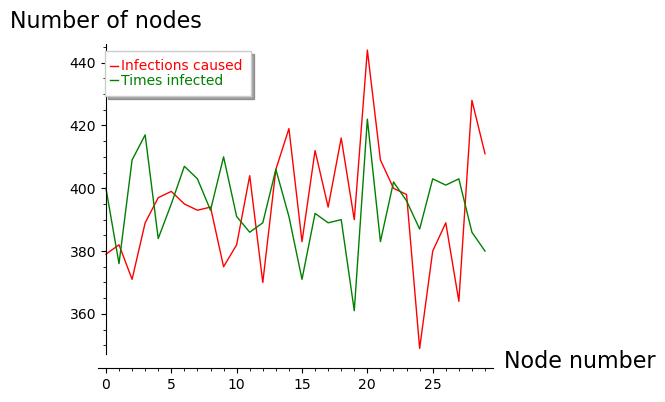

infected nodes, mean  24.5218458933108
infected nodes, std  2.34319612529320
susceptible nodes, mean  5.47815410668925
susceptible nodes, std  2.34319612529320
Infected per node, mean:  394.066666666667
Infected per node, std:  19.6713222621213
times been infected, mean:  394.100000000000
times been infected, std:  13.2985609799681
z = 23619


In [3]:
#SIS simulations
#complete
n = 30
k = graphs.CompleteGraph(n).to_directed()
t = transmissionProcess(k,0,1,5,-1,0,1,40)
l = t[0][3]
k = [l[i] for i in range(len(l))]
infected = [e[0] for e in k]
been_inf = [e[1] for e in k]
plotvalues1 = [(i,e) for i,e in infected]
plotvalues2 = [(i,e) for i,e in been_inf]
plot1 = line(plotvalues1, color = 'red',legend_label='Infector', legend_color='red',axes_labels=['Node label','Frequency'])
plot2 = line(plotvalues2, color = 'green',legend_label='Infectee', legend_color='green',axes_labels=['Node label','Frequency'])
show(plot1+plot2)
print('infected nodes, mean ',RR(mean(t[0][1])))
print('infected nodes, std ',RR(std(t[0][1])))
print('susceptible nodes, mean ',RR(mean(t[0][0])))
print('susceptible nodes, std ',RR(std(t[0][0])))
print('Infected per node, mean: ',RR(mean(infected)))
print('Infected per node, std: ',RR(std(infected)))
print('times been infected, mean: ',RR(mean(been_inf)))
print('times been infected, std: ',RR(std(been_inf)))
print("z = "+str(t[0][4]))

5
(1, 147)
(2, 18)
10
(1, 243)
(2, 45)
15
(1, 358)
(2, 90)
20
(1, 410)
(2, 121)
25
(1, 460)
(2, 117)


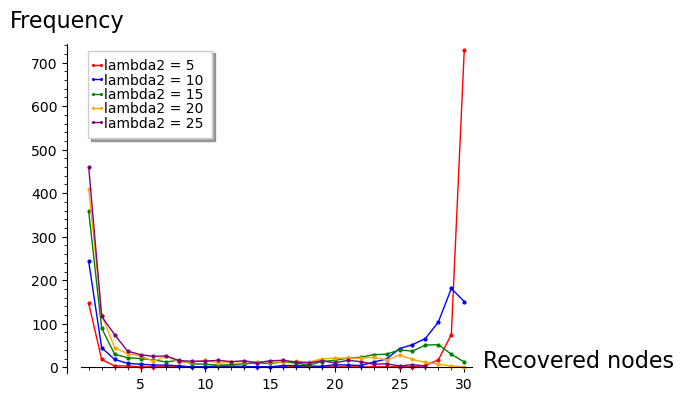

In [6]:
#SIR simulations
#complete
n = 30
m = 1000
lambda1 = 1
lambda2 = 6
plotvalues = []
lambdas = [5,10,15,20,25]
for i in lambdas:    
    gr = graphs.CompleteGraph(n).to_directed()
    t = [transmissionProcess(gr,0,lambda1,i,0,0) for _ in range(m)]
    #t = [SIR(gr,lambda1,i) for _ in range(m)]
    l = [n-e[0][0][-1] for e in t]
    k = CountsDict(l)
    plotvalues.append(sorted([(e,k[e]) for e in k]))
    print(i)
    print(plotvalues[-1][0])
    print(plotvalues[-1][1])
colorss = ['blue','green','orange','purple','yellow']

plot1 = line(plotvalues.pop(0), color = 'red',marker = 'o',markersize = 2,legend_label=f'lambda2 = {lambdas.pop(0)}',axes_labels=['Recovered nodes','Frequency'])
for i,e in enumerate(plotvalues):
    plot1 += line(e, color = colorss[i],marker = 'o',markersize = 2,legend_label=f'lambda2 = {lambdas[i]}',axes_labels=['Recovered nodes','Frequency'])

show(plot1)

1/2
(1, 18)
(2, 13)
1
(1, 35)
(2, 28)
5
(1, 144)
(2, 124)
10
(1, 263)
(2, 207)


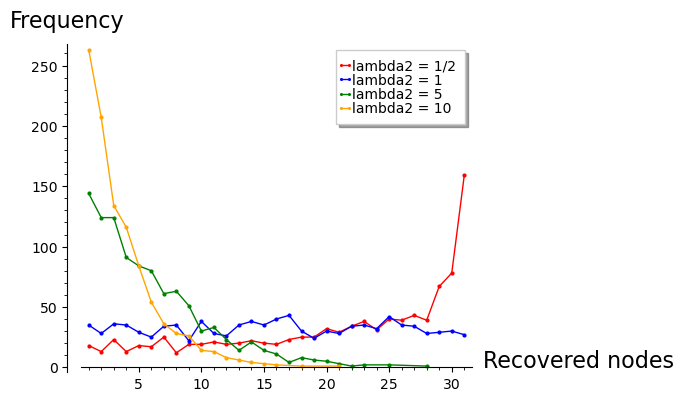

In [50]:
#SIR simulations
#star
n = 30
m = 1000
lambda1 = 1
lambda2 = 6
plotvalues = []
lambdas = [1/2,1,5,10]
for i in lambdas:    
    gr = graphs.StarGraph(n).to_directed()
    t = [transmissionProcess(gr,0,lambda1,i,0,0,0) for _ in range(m)]
    l = [n-e[0][0][-1] for e in t]
    k = CountsDict(l)
    plotvalues.append(sorted([(e+1,k[e]) for e in k]))
    print(i)
    print(plotvalues[-1][0])
    print(plotvalues[-1][1])
colorss = ['blue','green','orange']

plot1 = line(plotvalues.pop(0), color = 'red',marker = 'o',markersize = 2,legend_label=f'lambda2 = {lambdas.pop(0)}',axes_labels=['Recovered nodes','Frequency'])
for i,e in enumerate(plotvalues):
    plot1 += line(e, color = colorss[i],marker = 'o',markersize = 2,legend_label=f'lambda2 = {lambdas[i]}',axes_labels=['Recovered nodes','Frequency'])

show(plot1)

1/16
(1, 55)
(2, 44)
1/8
(1, 119)
(2, 101)
1/3
(1, 284)
(2, 179)
1
(1, 477)
(2, 285)


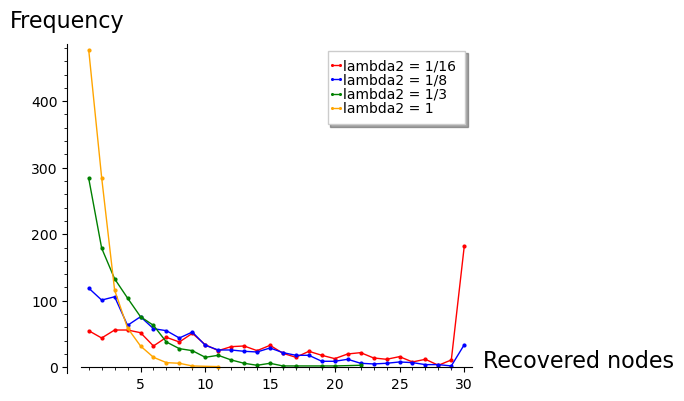

In [51]:
#SIR simulations
#path
n = 30
m = 1000
lambda1 = 1
lambda2 = 6
plotvalues = []
lambdas = [1/16,1/8,1/3,1]
for i in lambdas:    
    gr = graphs.PathGraph(n).to_directed()
    t = [transmissionProcess(gr,0,lambda1,i,0,0,0) for _ in range(m)]
    l = [n-e[0][0][-1] for e in t]
    k = CountsDict(l)
    plotvalues.append(sorted([(e,k[e]) for e in k]))
    print(i)
    print(plotvalues[-1][0])
    print(plotvalues[-1][1])
colorss = ['blue','green','orange']

plot1 = line(plotvalues.pop(0), color = 'red',marker = 'o',markersize = 2,legend_label=f'lambda2 = {lambdas.pop(0)}',axes_labels=['Recovered nodes','Frequency'])
for i,e in enumerate(plotvalues):
    plot1 += line(e, color = colorss[i],marker = 'o',markersize = 2,legend_label=f'lambda2 = {lambdas[i]}',axes_labels=['Recovered nodes','Frequency'])

show(plot1)

In [7]:
#star probs
print(RR(0.5/(30+0.5)*1000))
print(RR(30/(30+1/2)*0.5/(29+1)*(1+0.5/(29.5))*1000))

print(RR(1/(30+1)*1000))
print(RR(30/(30+1)*1/(29+2)*(1+1/(30))*1000))

print(RR(5/(30+5)*1000))
print(RR(30/(30+5)*5/(29+10)*(1+5/(34))*1000))

print(RR(10/(30+10)*1000))
print(RR(30/(30+10)*10/(29+20)*(1+10/(39))*1000))
print('')

#complete probs
print(RR(5/(29+5)*1000))
print(RR(2*29/(29+5)*(5/(56+10)*5/(28+5))*1000))

print(RR(10/(29+10)*1000))
print(RR(2*29/(29+10)*(10/(56+20)*10/(28+10))*1000))

print(RR(15/(29+15)*1000))
print(RR(2*29/(29+15)*(15/(56+30)*15/(28+15))*1000))

print(RR(20/(29+20)*1000))
print(RR(2*29/(29+20)*(20/(56+40)*20/(28+20))*1000))

print(RR(25/(29+25)*1000))
print(RR(2*29/(29+25)*(25/(56+50)*25/(28+25))*1000))
print('')

#path probs
print(RR(1/(1+1)*1000))
print(RR(1/(1+1)*1/(1+2)*(1+1/(1+1))*1000))

print(RR(1/3/(1+1/3)*1000))
print(RR(1/(1+1/3)*1/3/(1+2/3)*(1+1/3/(1+1/3))*1000))
      
print(RR(1/8/(1+1/8)*1000))
print(RR(1/(1+1/8)*1/8/(1+2/8)*(1+1/8/(1+1/8))*1000))
      
print(RR(1/16/(1+1/16)*1000))
print(RR(1/(1+1/16)*1/16/(1+2/16)*(1+1/16/(1+1/16))*1000))

16.3934426229508
16.6712975826619
32.2580645161290
32.2580645161290
142.857142857143
126.050420168067
250.000000000000
192.307692307692

147.058823529412
19.5808350888565
256.410256410256
51.4951345976277
340.909090909091
80.2030581641182
80.2030581641182
408.163265306122
102.749433106576
462.962962962963
119.490262779690

500.000000000000
250.000000000000
250.000000000000
187.500000000000
111.111111111111
98.7654320987654
58.8235294117647
55.3633217993080


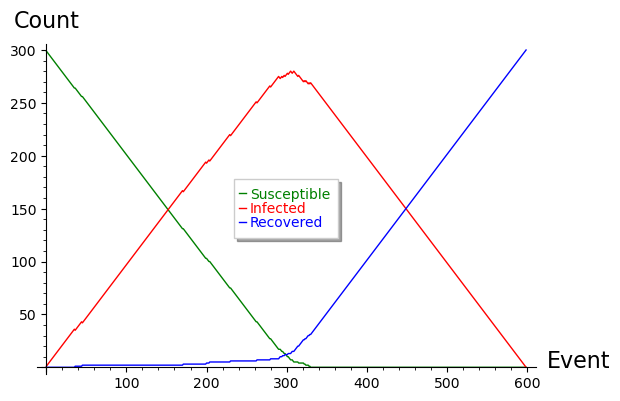

3000 events, stopping simulation.


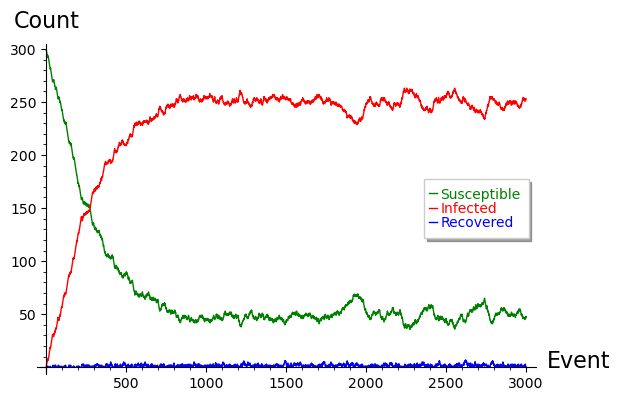

3000 events, stopping simulation.


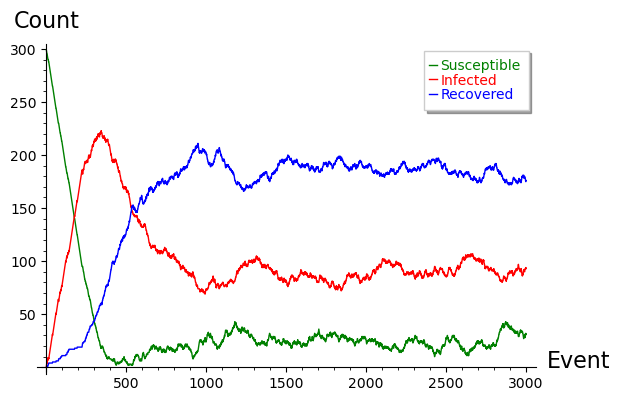

In [14]:
#presentation sims
#SIRS simulations
#complete
n = 300
k = graphs.CompleteGraph(n).to_directed()
t = SIRS(k,1,5,0.01,plt=1) #kinda SIR
t = SIRS(k,1,50,10000,plt=1) #kinda SIS
t = SIRS(k,1,2,1,plt=1,p_b=0.9) #p block
#t = SIRS(k,1,1,2,plt=1,p_b=4,z_end=15000) #p block, remember to change p_b and n=300

15000 events, stopping simulation.


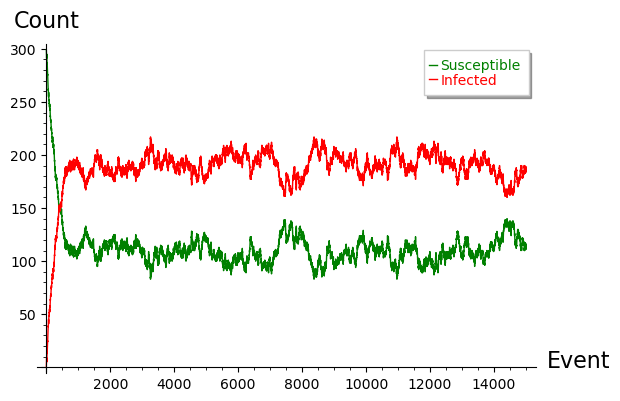

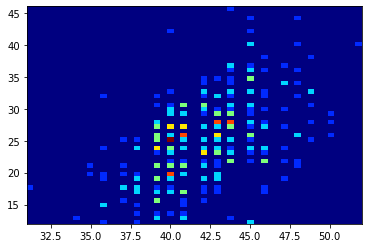

'\n    \n\nnode_lex_ti = {}\nfor i in range(n):\n    node_lex_ti[i] = k.in_degree(i)     \n    \nnode_lex2_ti = {}\nfor i,e in enumerate(node_lex_ti.values()):\n    node_lex2_ti[e] = (node_lex2_ti[e] + [i]) if (e in node_lex2_ti) else [i]\n    \nti_lex = {}\nfor i,e in enumerate(node_lex2_ti):\n    ti_lex[e] = [l[y][1] for y in node_lex2_ti[e]]\n    \nplot_values_ti = []\nfor i in ti_lex:\n    for j in ti_lex[i]:\n        plot_values_ti.append((i,j))\n        \n\n\nplot_mean_ti = sorted([(e,mean(ti_lex[e])) for e in ti_lex])\npl = line(plot_mean_ti,color=\'red\',axes_labels=["Neighbours","Infectee frequency"])\npl2 = points(plot_values_ti,color=\'blue\')\nshow(pl+pl2)   \n'

In [14]:
#SIS simulations
#Small World
import matplotlib.pyplot as plt
n = 300
k0 = n/10
p = 0.4
k = graphs.RandomNewmanWattsStrogatz(n, k0,p).to_directed()
t = transmissionProcess(k,0,1,15,-1,0,1,15000)
l = t[0][3]
k2 = list(l.values())

node_lex_ic = {}
for i in range(n):
    node_lex_ic[i] = k.out_degree(i)
    
node_lex2_ic = {}
for i,e in enumerate(node_lex_ic.values()):
    node_lex2_ic[e] = (node_lex2_ic[e] + [i]) if (e in node_lex2_ic) else [i]

ic_lex = {}
for i,e in enumerate(node_lex2_ic):
    ic_lex[e] = [l[y][0] for y in node_lex2_ic[e]]
    
plot_values_ic = []
for i in ic_lex:
    for j in ic_lex[i]:
        plot_values_ic.append([i,j])  

plot_mean_ic = sorted([(e,mean(ic_lex[e])) for e in ic_lex])
pl = line(plot_mean_ic,color='red',axes_labels=["Neighbours","Infector frequency"])
pl2 = plt.hist2d([e[0] for e in plot_values_ic],[e[1] for e in plot_values_ic],bins=(50,50),cmap=plt.cm.BuPu)
plt.show()
"""
    

node_lex_ti = {}
for i in range(n):
    node_lex_ti[i] = k.in_degree(i)     
    
node_lex2_ti = {}
for i,e in enumerate(node_lex_ti.values()):
    node_lex2_ti[e] = (node_lex2_ti[e] + [i]) if (e in node_lex2_ti) else [i]
    
ti_lex = {}
for i,e in enumerate(node_lex2_ti):
    ti_lex[e] = [l[y][1] for y in node_lex2_ti[e]]
    
plot_values_ti = []
for i in ti_lex:
    for j in ti_lex[i]:
        plot_values_ti.append((i,j))
        


plot_mean_ti = sorted([(e,mean(ti_lex[e])) for e in ti_lex])
pl = line(plot_mean_ti,color='red',axes_labels=["Neighbours","Infectee frequency"])
pl2 = points(plot_values_ti,color='blue')
show(pl+pl2)   
"""

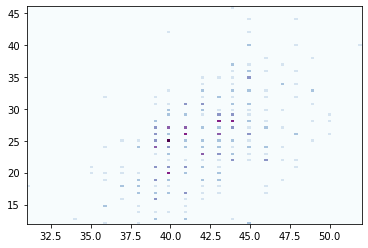

In [17]:
pl2 = plt.hist2d([e[0] for e in plot_values_ic],[e[1] for e in plot_values_ic],bins=(100,100),cmap=plt.cm.BuPu)
plt.show()

In [13]:
DensityPlot?